In [1]:
import pandas as pd
import numpy as np
import random
import math as m
import matplotlib.pyplot as plt
import statistics as s

# Read the data

In [4]:
xtrain = pd.read_csv('Musk1.csv', sep = ',', header= None)

In [44]:
n_cols = xtrain.shape[1]
xtrain.columns = [str(i) for i in range(n_cols)]

In [ ]:
xtrain.columns

# Introduction

Lets first run a classification on the instance based data with using the bag labels as instance labels and see if there are features that are important in this classification:

In [13]:
from pycaret.classification import *

In [129]:
init_model = setup(data = xtrain, 
                  target = '0',
                  ignore_features = '1',
                  normalize = True,
                   fold = 10,
                   silent= True
                  )

,Description,Value
0,session_id,4973
1,Target,0
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(476, 168)"
5,Missing Values,False
6,Numeric Features,166
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [147]:
output = compare_models(include= ['rf','dt','gbc','knn','lightgbm'], n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8855,0.9403,0.9429,0.8213,0.8741,0.7702,0.7829,0.0420
rf,Random Forest Classifier,0.8799,0.9424,0.8314,0.8887,0.8547,0.7529,0.7593,0.2640
lightgbm,Light Gradient Boosting Machine,0.8798,0.9552,0.8371,0.8808,0.8533,0.7520,0.7587,0.1540
gbc,Gradient Boosting Classifier,0.8797,0.9628,0.8238,0.8879,0.8501,0.7505,0.7570,0.4920
dt,Decision Tree Classifier,0.7832,0.7747,0.7176,0.7662,0.7353,0.5529,0.5591,0.0280


In [151]:
evaluate_model(output[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

As seen, there are features that are important in explaining the class of the instances and there are features that are of no use at all. Therefore, I decided to use only the most important features (I decided to use 32 of them, which seems a reasonable choice as it corresponds roughly 20% of all features and their importance figure seems high to me) and then train the model with only those features to see their individual effects on the output:

# Representation Application

In [153]:
init_model = setup(data = xtrain[['93','163','103','38','37','71','117','84','149','134','130','98','44','7','66','110','85','164','69','11','22','127','137','113','43','12','24','128','166','167','148','153','0','1']], 
                  target = '0',
                  ignore_features = '1',
                  normalize = True,
                   fold = 10,
                   silent= True
                  )

,Description,Value
0,session_id,1101
1,Target,0
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(476, 34)"
5,Missing Values,False
6,Numeric Features,32
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [154]:
output2 = compare_models(include= ['rf','dt','gbc','knn','lightgbm'], n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8983,0.9496,0.8795,0.8949,0.8773,0.7911,0.8032,0.2750
gbc,Gradient Boosting Classifier,0.8830,0.9513,0.8581,0.8719,0.8599,0.7597,0.7662,0.1700
rf,Random Forest Classifier,0.8802,0.9458,0.8295,0.8903,0.8531,0.7524,0.7603,1.0880
knn,K Neighbors Classifier,0.8503,0.9153,0.8514,0.8174,0.8282,0.6961,0.7046,0.0220
dt,Decision Tree Classifier,0.8079,0.8087,0.8152,0.7566,0.7813,0.6106,0.6171,0.0160


In [155]:
evaluate_model(output2[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

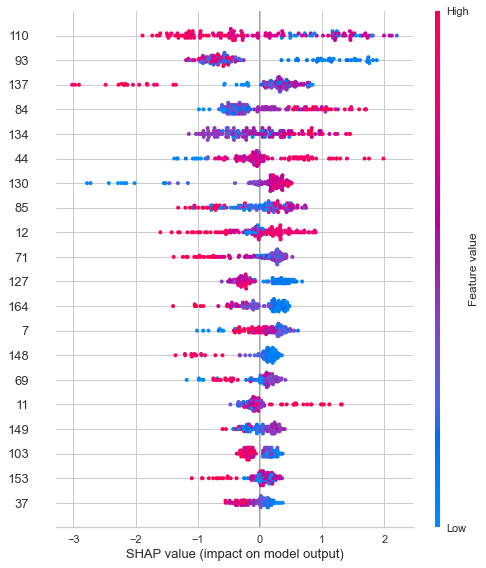

In [156]:
interpret_model(output2[0])

As seen from the above SHAP values of the features, we could claim that some of the features are affecting the output when they are minimum or maximum, otherwise the effect of individual features seems to be mixed (high when large for some instances and high when small for some other instances). Therefore, making use of these SHAP values for the individual features, I decided to aggregate them for the bags according to their main effects, namely, taking the minimum, maximum, or the average of them for the bag features.  

# Bag Classification

In [157]:
xtrain_new = xtrain[['93','163','103','38','37','71','117','84','149','134','130','98','44','7','66','110','85','164','69','11','22','127','137','113','43','12','24','128','166','167','148','153','0','1']] 
                 

In [158]:
xtrain_mins = xtrain_new[['0','1','38','93','163','37','130','164','127']].groupby(['1']).min()
xtrain_maxs = xtrain_new[['0','1','71','117','84','66','110','85','11','137','148','153']].groupby(['1']).max()
xtrain_avgs = xtrain_new[['0','1','103','149','134','98','44','7','69','22','113','43','12','24','128','166','167']].groupby(['1']).mean()

In [159]:
xtrain_gr = pd.merge(pd.merge(xtrain_mins, xtrain_maxs, on = ['1']), xtrain_avgs, on = ['1'])

In [161]:
xtrain_gr.columns

Index(['0_x', '38', '93', '163', '37', '130', '164', '127', '0_y', '71', '117',
       '84', '66', '110', '85', '11', '137', '148', '153', '0', '103', '149',
       '134', '98', '44', '7', '69', '22', '113', '43', '12', '24', '128',
       '166', '167'],
      dtype='object')

In [162]:
fin_model = setup(data = xtrain_gr[['38', '93', '163', '37', '130', '164', '127', '71', '117',
       '84', '66', '110', '85', '11', '137', '148', '153', '0', '103', '149',
       '134', '98', '44', '7', '69', '22', '113', '43', '12', '24', '128',
       '166', '167']], 
                  target = '0',
                  #ignore_features = '1',
                  normalize = True,
                   fold = 10,
                   silent= True
                  )

,Description,Value
0,session_id,4548
1,Target,0
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(92, 33)"
5,Missing Values,False
6,Numeric Features,31
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


Then I trained another supervised learning model to make the classification for the bags:

In [167]:
output_f = compare_models(include= ['rf','lr','gbc','ada','knn','dt'], n_select= 2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8286,0.9056,0.8417,0.8700,0.8235,0.6504,0.6916,0.0180
rf,Random Forest Classifier,0.8238,0.9111,0.8417,0.8667,0.8213,0.6445,0.6886,0.2170
gbc,Gradient Boosting Classifier,0.8214,0.9222,0.9000,0.8267,0.8406,0.6391,0.6843,0.0770
knn,K Neighbors Classifier,0.8071,0.9181,0.9667,0.7567,0.8401,0.6112,0.6423,0.0250
ada,Ada Boost Classifier,0.7810,0.8333,0.9083,0.7400,0.7999,0.5532,0.6058,0.0800
dt,Decision Tree Classifier,0.7476,0.7375,0.8417,0.7767,0.7878,0.4841,0.4875,0.0140


As seen, the accuracy of Logistic regression and Random Forest Classifier seems to outperform other algorithms of my choice. Therefore, I would continue with these two models and see their performance: 

In [168]:
evaluate_model(output_f[0])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [169]:
evaluate_model(output_f[1])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

As expected from the model performances indicated in the training, Logistic Regression performs better on the testing phase as it classifies 23 out of 28 instances in the test data, while Random Forest Classifier seems to classify 22 of 28 instances correctly.